# Temperatura externa y consumo de energía

Se modelará el consumo de energía de un edicifio a partir de la temperatura externa (_Outdoor Air Temperature (OAT)_) y otra información (ej. la hora del día) como variables predictivas en un algoritmo de regresión lineal.

In [1]:
#---  Librerías ---#
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats

from sklearn.model_selection import train_test_split
import glob

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

## 1. Importar y organizar datos

Se utilizará el dataset correspondiente a _Long-term energy consumption & outdoor air temperature for 11 commercial buildings_ disponible en [OpenEI](https://openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e).

Solo se toman los 5 edificios cuyo set de datos está en estado _retail_ y, se une toda la información en un solo DataFrame.

In [2]:
#--- importamos los archivos ---#

# Especificamos el path de todos los archivos csv
all_files = glob.glob('building_data/*.csv')

li = []

# Importamos un df para cada path de archivo 
for file in all_files:
    #importamos usando la fecha como indice
    df = pd.read_csv(file, index_col=[0], parse_dates=True)
    li.append(df)

In [3]:
li[0].tail(10)

,OAT (F),Power (kW)
Timestamp,,
2010-12-30 21:45:00,48,284.1
2010-12-30 22:00:00,48,273.4
2010-12-30 22:15:00,48,196.7
2010-12-30 22:30:00,48,185.0
2010-12-30 22:45:00,48,163.1
2010-12-30 23:00:00,48,165.1
2010-12-30 23:15:00,48,157.6
2010-12-30 23:30:00,48,166.8
2010-12-30 23:45:00,48,164.0


In [4]:
li[0].shape

(34940, 2)

In [5]:
#--- concatenamos toda la información ---#
data = pd.concat(li, axis=0)

In [6]:
#--- vistazo a los datos ya concatenados ---#
data.sample(10)

,OAT (F),Power (kW)
Timestamp,,
2010-11-13 13:30:00,53,254.7
2010-04-01 09:00:00,49,278.9
2010-04-09 15:15:00,53,280.5
2010-10-08 10:00:00,59,293.1
2010-09-03 16:45:00,90,0.0
2010-04-29 22:15:00,70,205.9
2010-12-20 23:00:00,58,307.4
2010-12-26 20:30:00,54,328.2
2010-05-01 07:45:00,63,167.6


In [7]:
#--- Tamaño del set de datos ya concatenado ---#
data.shape

(174700, 2)

In [8]:
#--- Obteniendo caracteristicas de los indices (Timestamp) ---#
data.index[0].year

2010

Notemos entonces que la fuente de datos es pública, por lo cual __no hay conflictos de intereses__ a la hora de analizar estos datos. __No se requiere ningún permiso especial para el acceso, manipulación y discusión de resultados del presente notebook__. 

## 2. Exploración de los datos

Se realizará una indagación sobre la información obtenida y se buscará la mejor forma de limpiar el dataset disponible.

- Revisamos si hay valores faltantes.

In [9]:
# --- despliega la cantidad de valores faltantes por columna --- #
data.isnull().sum()

OAT (F)       0
Power (kW)    0
dtype: int64

- Hacemos un primer gráfico para ver como son los datos 

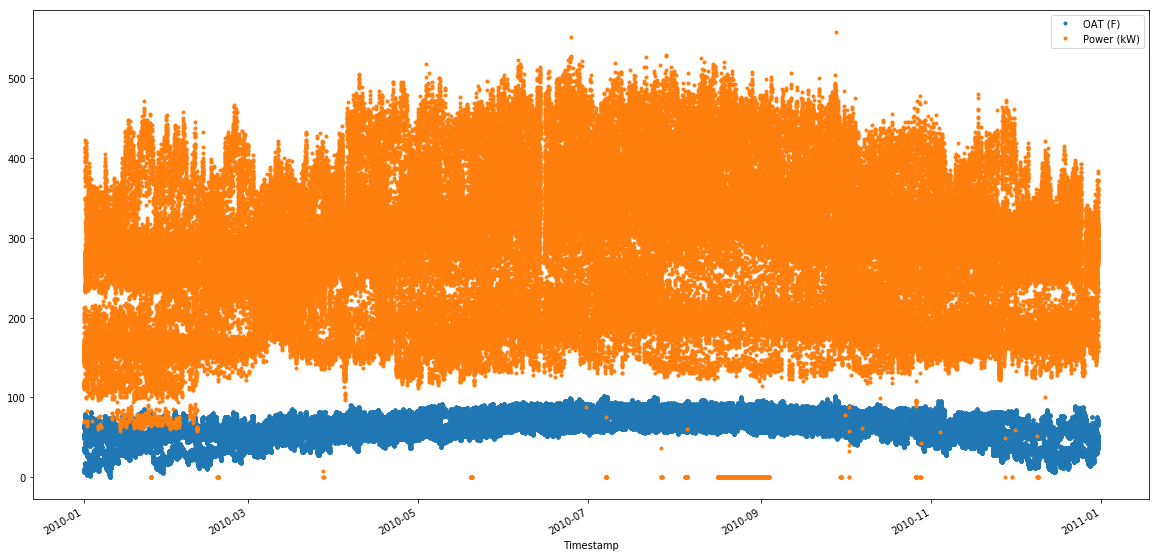

In [10]:
data.plot(figsize=(20,10), style='.')

A partir de este gráfico de dispersión podemos ver una región clara donde pertenecen los datos de _OAT_ y, en el caso de _Power_ hay un poco más de variación alrededor del área donde tienden los datos. 

- Hacemos un segundo gráfico para ver si hay un comportamiento estadistico claro, por ejemplo, una distribución gaussiana para los valores numéricos. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4532810518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4531e14da0>]], dtype=object)

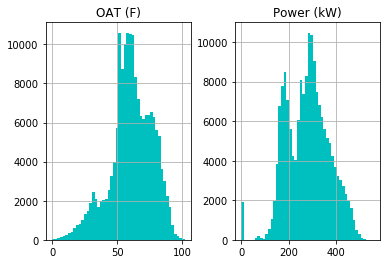

In [11]:
data.hist(color="c", bins=50)

De estos histograas podemos notar que, al juntar la infomación de varios edificios hay dos "picos" para el consumo de energía (Power kW). Mientras que, la temperatura externa OAT se mantiene con un comportamiento gaussiano de un solo pico muy marcado. 


## 3. Limpieza de los datos 

Realizaremos una copia de los datos originales y trabajaremos sobre dicho DataFrame de ahora en adelante, de esta manera se podrá volver a la información original en caso de aplicar un método no exitoso sobre los datos. 

In [12]:
# --- copiamos el conjunto de datos original --- #
dataset = data.copy()

Primero vamos a identificar si hay algún _Outlier_ en los datos que deba ser removido para mejorar el rendimiento de algún ajuste posterior. El siguiente análisis se realiza teniendo en cuenta las sugerencias en [towardsdatascience](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba).

- Realizamos un gráfico de caja (Box Plot) para la visualización de los _Outliers_


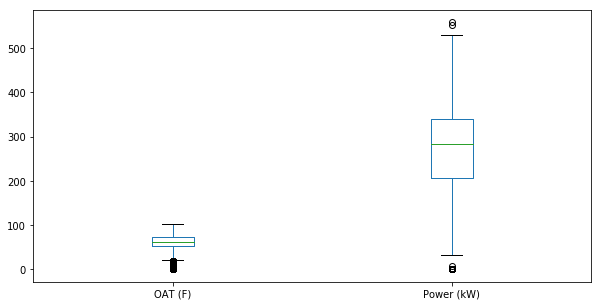

In [13]:
dataset.plot(kind='box', figsize=(10,5))

A partir del Box Plot podemos notar varias cosas: 
1. Los cuartiles están relativamente centrados con respecto a la variabilidad de los datos.
2. Hay varios puntos (datos) que no son agrupados dentro de los cuartiles, es decir, hay varios outliers tanto en _OAT (F)_ como en _Power (kW)_.

De esta manera, con el fin de remover los _Outliers_ identificados en el Box Plot, se propone usar el _IQR score_ para hacer nuestra limpieza de los datos. 

> El **rango intercuartil (IQR)** es una medida de dispersión estadistica la cual se calcula a partir de la diferencia entre los cuartiles superior e inferior (75vo y 25vo). $$ IQR = Q3 - Q1 $$ Esta medida es similar a la desviación estandar o a la varianza pero es mucho más robusta contra los _Ouliers_.


In [14]:
# --- calculamos los cuartiles y el IQR para nuestros datos --- #

Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)

IQR = Q3-Q1

print(IQR)

OAT (F)        21.000
Power (kW)    132.825
dtype: float64


- Separamos los datos de acuerdo al IQR. 

Se crea un nuevo df con los datos limpios

In [15]:
# --- df limpio --- #
clean_data = dataset[~((dataset < (Q1 - 0.8 * IQR)) |(dataset > (Q3 + 0.8 * IQR))).any(axis=1)]

In [16]:
clean_data.shape

(151192, 2)

Para visualizar los datos eliminados vamos a gráficar en un mismo plot los datos completos y los datos limpios.

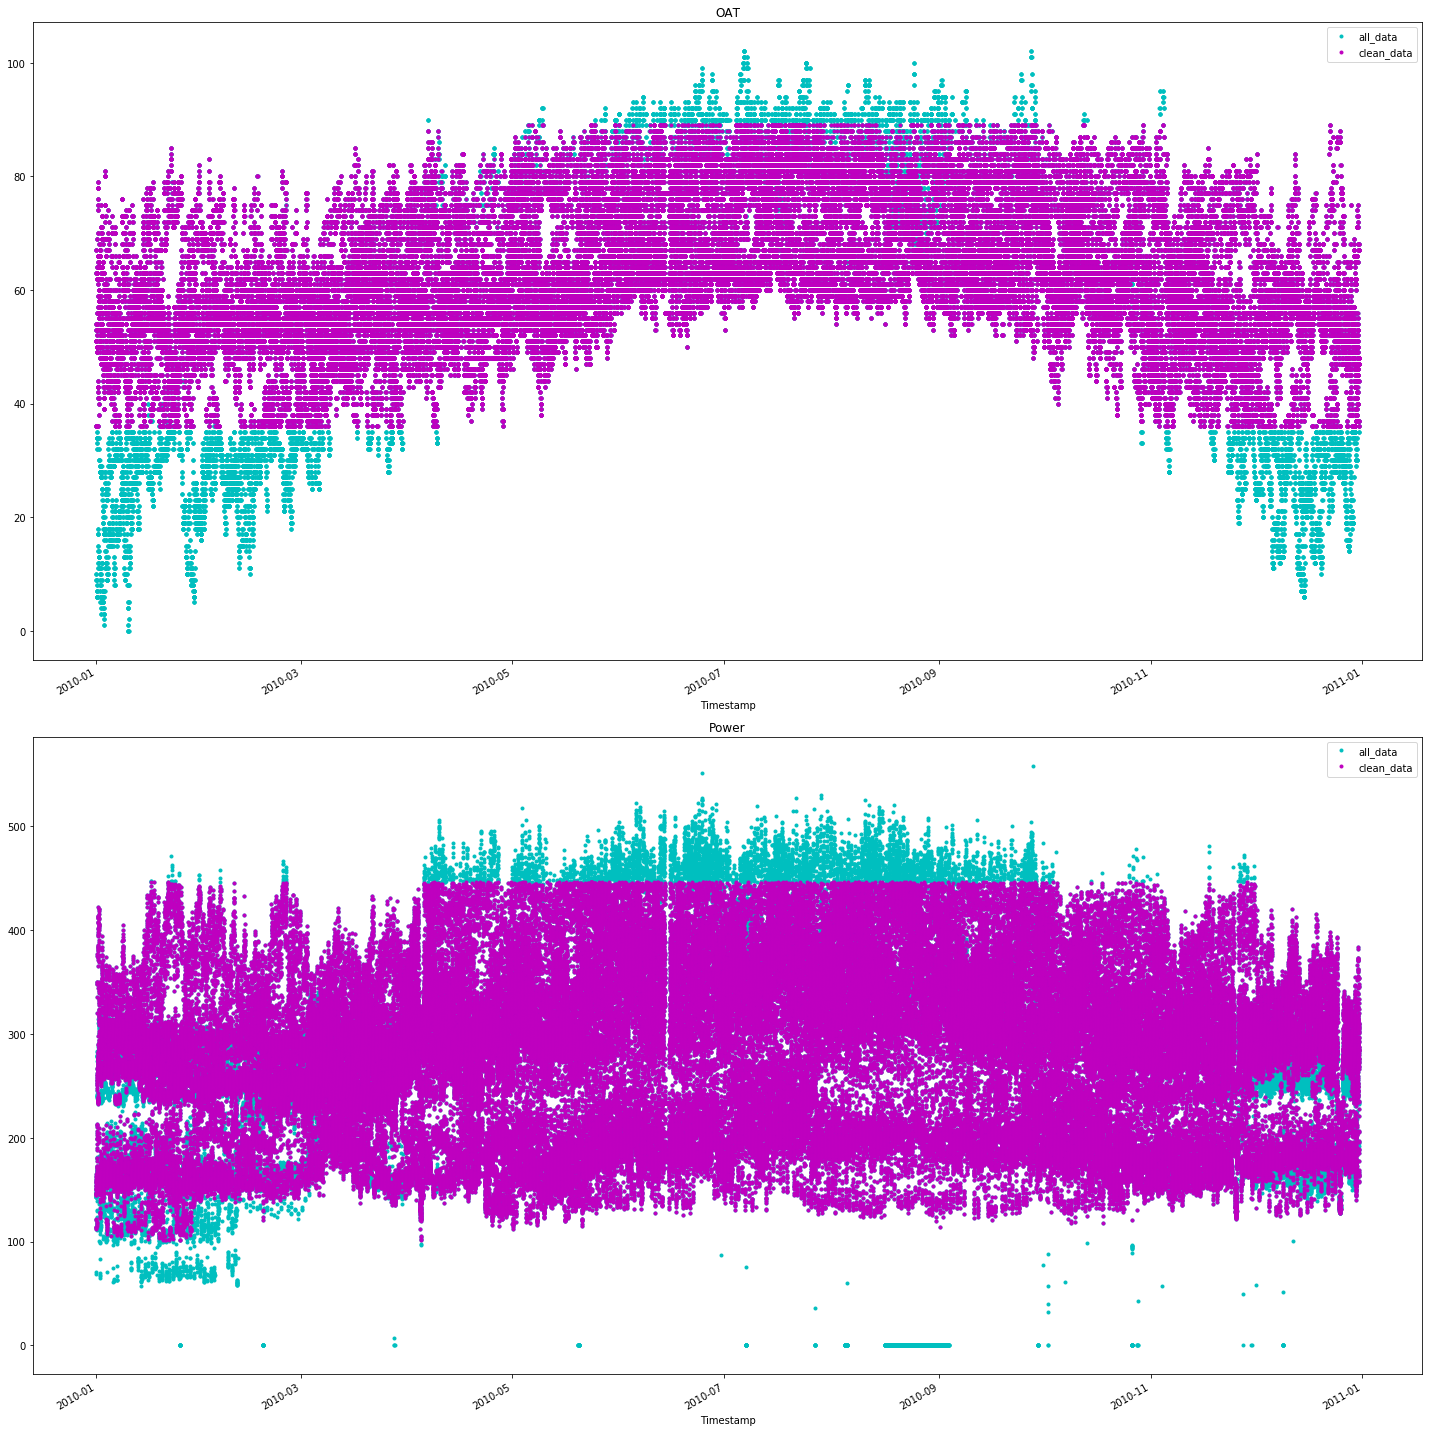

In [17]:
fig, [ax1, ax2] = plt.subplots(2, figsize=(20,20))

ax1.set_title('OAT')
data['OAT (F)'].plot(style='.', ax=ax1, label='all_data', color='c')
clean_data['OAT (F)'].plot(style='.', ax=ax1, label='clean_data', color='m')
ax1.legend()

ax2.set_title('Power')
data['Power (kW)'].plot(style='.', ax=ax2, label='all_data', color='c')
clean_data['Power (kW)'].plot(style='.', ax=ax2, label='clean_data', color='m')
ax2.legend()

plt.tight_layout()
plt.show()

Ya con los datos limpios, procedemos con el modelo de nuestro sistema.